In [1]:
import sys
#sys.path.append('/home/sergio/Documentos/MemoriaPractII/Open Ephys/analysis-tools-master')
sys.path.append('/home/cmanalisis/Aquiles/Registros/Phyton/analysis-tools-master')

In [2]:
%matplotlib notebook
import pickle
from glob2 import glob
import OpenEphys as OE
import os
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#import statistics as stats

In [3]:
# definir el root path del directorio donde estan los archivos
# El backslash al final de 
### Control Salino
#rootpath = '/home/cmanalisis/1_SergioEhijo/Ratas/ControlSalino/CA_EC03_NS__2018-09-05_13-14-43/' 
# Alex
rootpath = '/home/cmanalisis/1_SergioEhijo/Ratas/C14_Alex/CA_EC03_C14_PreQx__2018-09-12_15-12-28/'
fullpath = rootpath + '*CH*.continuous'
lista = glob(fullpath)
lista = sorted(lista)
lista

['/home/cmanalisis/1_SergioEhijo/Ratas/C14_Alex/CA_EC03_C14_PreQx__2018-09-12_15-12-28/100_CH1.continuous',
 '/home/cmanalisis/1_SergioEhijo/Ratas/C14_Alex/CA_EC03_C14_PreQx__2018-09-12_15-12-28/100_CH10.continuous',
 '/home/cmanalisis/1_SergioEhijo/Ratas/C14_Alex/CA_EC03_C14_PreQx__2018-09-12_15-12-28/100_CH11.continuous',
 '/home/cmanalisis/1_SergioEhijo/Ratas/C14_Alex/CA_EC03_C14_PreQx__2018-09-12_15-12-28/100_CH12.continuous',
 '/home/cmanalisis/1_SergioEhijo/Ratas/C14_Alex/CA_EC03_C14_PreQx__2018-09-12_15-12-28/100_CH13.continuous',
 '/home/cmanalisis/1_SergioEhijo/Ratas/C14_Alex/CA_EC03_C14_PreQx__2018-09-12_15-12-28/100_CH14.continuous',
 '/home/cmanalisis/1_SergioEhijo/Ratas/C14_Alex/CA_EC03_C14_PreQx__2018-09-12_15-12-28/100_CH15.continuous',
 '/home/cmanalisis/1_SergioEhijo/Ratas/C14_Alex/CA_EC03_C14_PreQx__2018-09-12_15-12-28/100_CH16.continuous',
 '/home/cmanalisis/1_SergioEhijo/Ratas/C14_Alex/CA_EC03_C14_PreQx__2018-09-12_15-12-28/100_CH17.continuous',
 '/home/cmanalisis/1

In [4]:
# obtain sampling rate from first channel to obtain samplin freq
i = 0
data = OE.loadContinuous(lista[i])
ad = data['data']
orSampleRate = int(data['header']['sampleRate'])
Nyquist = orSampleRate/2
print(Nyquist)
data

Loading continuous data...
15000.0


{'data': array([64.545, 66.495, 66.495, ...,  0.   ,  0.   ,  0.   ]),
 'header': {' date_created': "'12-Sep-2018 151228'",
  ' header_bytes': '1024',
  ' version': '0.4',
  'bitVolts': '0.195',
  'blockLength': '1024',
  'bufferSize': '1024',
  'channel': "'CH1'",
  'channelType': "'Continuous'",
  'description': "'each record contains one 64-bit timestamp, one 16-bit sample count (N), 1 uint16 recordingNumber, N 16-bit samples, and one 10-byte record marker (0 1 2 3 4 5 6 7 8 255)'",
  'format': "'Open Ephys Data Format'",
  'sampleRate': '30000'},
 'recordingNumber': array([0., 0., 0., ..., 0., 0., 0.]),
 'timestamps': array([ 1294592.,  1295616.,  1296640., ..., 76709120., 76710144.,
        76711168.])}

<IPython.core.display.Javascript object>


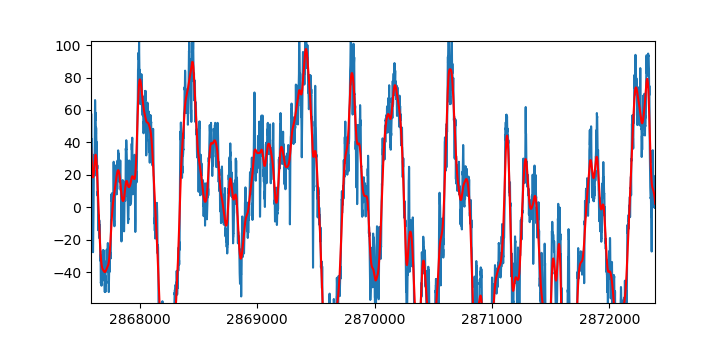

/home/cmanalisis/anaconda2/envs/py3-env/lib/python3.5/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [5]:
#muestra de como queda la señal despues de filtrar
# opcional
fig, ax = plt.subplots()
ax.plot(ad)
#mpl.rcParams['agg.path.chunksize'] = 100000 #Para arreglar porblema "OverflowError: In draw_path: Exceeded cell block limit" entra Matplotlib y Tkinter
# filter the signal
# scipy.signal.filtfilt(b, a, x, axis=-1, padtype='odd', padlen=None, method='pad', irlen=None)[source]
#b, a = signal.butter(8, 0.125)
N = 2 
#Bandpass parameters
#f1 = 1.0
#f2 = 300.0
#Wn = np.array([f1/Nyquist, f2/Nyquist])
#b,a = scipy.signal.butter(N, Wn, btype='bandpass', analog=False)
Wn = 450/Nyquist
b,a = scipy.signal.butter(N, Wn, analog=False)
adfilt = scipy.signal.filtfilt(b, a, ad, padlen=None)
ax.plot(adfilt,'r')
plt.show()

In [ ]:
# For bandpass filtering:
# low cutoff freq
#f1 = 1.0
# high cut off freq
#f2 = 150.0
# band pass freqs expressed as Nyquist
#Wn = array([f1/Nyquist, f2/Nyquist])
# design parameters for the butter filter
#b,a = scipy.signal.butter(N, Wn, btype='bandpass', analog=False)

### Frequency decimation: low pass filtering (450 Hz) and Downsampling (30kS/sec to 1kS/sec)

In [16]:
#From here on, frequency decimation using a low pass filter and then downsampling.
channelcodes = 'channels_EC03.csv'
# order of the butter filter
N = 2
# low pass cut off frequency
f1 = 450
Wn = f1/Nyquist
b,a = scipy.signal.butter(N, Wn, analog=False)
desiredSampleRate = 1000.0
codes_df = pd.read_csv('/home/cmanalisis/1_SergioEhijo/'+channelcodes)
df = pd.DataFrame([], columns=['Channel', 
                               'Area',
                               'OriginalSampleRate',
                               'SampleRate',
                               'Use',
                               'Timestamps at original sample rate',
                               'LFP'])
for i in range(0,len(lista)):
    #print i, lista[i]
    # lee el archivo en el i-esimo lugar de la lista y lo coloca en el diccionario data
    data = OE.loadContinuous(lista[i])
    # coloca la key data en el array aux
    aux = data['data']
    # filter the lfp signal in place
    aux = scipy.signal.filtfilt(b, a, aux, padlen=None)
    # hace el donwsampling desde el sampling original hasta 1000 Hz
    downsamplefactor = int(orSampleRate/desiredSampleRate)
    # multiplo de downsampling factor
    multiplo_dsf = int(len(aux)/downsamplefactor)
    
    # crear array de n x downsamplefactor para promediar 
    aux2 = aux[0:downsamplefactor*multiplo_dsf].reshape(-1, downsamplefactor)
    
    # promedio y con esto el downsampling esta finalizado
    aux2 = aux2.mean(axis=1)
    
    # crear eje de tiempo para la señal down-sampleada
    t2 = np.arange(1/desiredSampleRate,len(aux2)/desiredSampleRate + 1/desiredSampleRate,1/desiredSampleRate)
    # guarda el nombre del canal en channel
    # adquiere el nombre del canal, remueve comillas extras
    channel = data['header']['channel'].strip("'")
    auxaux = codes_df.Area[codes_df.Channel==channel]
    area = auxaux.values[0]
    df2 = pd.DataFrame([[channel,
                         area,
                         orSampleRate,
                         desiredSampleRate,
                         1,
                         data['timestamps'],
                         aux2]],
                       columns=['Channel',
                                'Area',
                                'OriginalSampleRate',
                                'SampleRate',
                                'Use',
                                'Timestamps at original sample rate',
                                'LFP'])
    df = pd.concat([df, df2], axis = 0) 
    #break
df.index = range(0, len(lista))

Loading continuous data...


/home/cmanalisis/anaconda2/envs/py3-env/lib/python3.5/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
L

In [21]:
# guardar el data frame con los LFP a un archivo pickle
# poner aqui nombre del archivo pickle que se quiere guardar
# nombre sujeto, fecha, condicion, etc.
file2save = 'CA_EC03_C14'
#Para python3, raw_input paso a ser input()
#answer = raw_input('Cambió el nombre del archivo de output? (s/n):')
rootpath2 = '/home/cmanalisis/1_SergioEhijo/Ratas/C14_Alex/Pickles/'
answer = input('Cambió el nombre del archivo de output? (s/n):')
if answer == 'n':
    print ('Entonces cambielo')
elif answer == 's':
    print ('Guardando...')
    pickle.dump( df, open( rootpath2 + 
                          'Decimated_LFP_' + file2save + '.pickle', "wb" ) )
    # print('Archivo',file2save)
else:
    print ('Entonces cambielo')
    

Cambió el nombre del archivo de output? (s/n):s
Guardando...


In [22]:
# Guarda archivo con los timestamps del LFP
pickle.dump([orSampleRate,data['timestamps']],
            open( rootpath2 +
                 'LFP_timestamps_' + file2save + '.pickle', "wb" ) )